In [ ]:
!pip install mlflow
!pip uninstall -y dgl
!pip install dgl==1.0.3 -f https://data.dgl.ai/wheels/repo.html


Found existing installation: dgl 1.1.0+cu117
Uninstalling dgl-1.1.0+cu117:
  Successfully uninstalled dgl-1.1.0+cu117
Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 54.5 MB/s eta 0:00:0000:0100:01


In [ ]:
# Kaggle environment - list available datasets
import os
print("Available datasets in /kaggle/input/:")
if os.path.exists("/kaggle/input/"):
    for item in os.listdir("/kaggle/input/"):
        print(f"- {item}")
else:
    print("Running locally - /kaggle/input/ not found")

Available datasets in /kaggle/input/:
- fraud-fulldata
- transactions-fraud-datasets
- filtered-data


In [ ]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, to_date, when
from pyspark.sql.types import FloatType
import polars as pl

In [ ]:
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Stop existing Spark session if any
try:
    spark.stop()
    print("Stopped existing Spark session")
except:
    pass

# Optimized Spark configuration
conf = SparkConf()\
    .setAppName("FraudDetection")\
    .set("spark.sql.shuffle.partitions", "200")\
    .set("spark.sql.autoBroadcastJoinThreshold", "50MB")\
    .set("spark.executor.memoryOverhead", "4g")\
    .set("spark.driver.memory", "16g")\
    .set("spark.executor.memory", "8g")\
    .set("spark.memory.fraction", "0.6")\
    .set("spark.memory.storageFraction", "0.4")\
    .set("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:MaxGCPauseMillis=200")\
    .set("spark.driver.maxResultSize", "4g")\
    .set("spark.default.parallelism", "200")\
    .set("spark.memory.offHeap.enabled", "true")\
    .set("spark.memory.offHeap.size", "4g")

# Initialize Spark session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# Set checkpoint directory
try:
    spark.sparkContext.setCheckpointDir("/tmp/spark-checkpoint")
except:
    pass

# Verify configuration
print("Spark session initialized with memory optimization")
print(f"Spark version: {spark.version}")
print(f"Driver memory: {spark.conf.get('spark.driver.memory')}")
print(f"Executor memory: {spark.conf.get('spark.executor.memory')}")

Stopped existing Spark session
Spark session initialized with memory optimization
Spark version: 3.5.5
Driver memory: 16g
Executor memory: 8g


In [ ]:
# Define file locations for Kaggle environment

cards = "/kaggle/input/transactions-fraud-datasets/cards_data.csv"
users = "/kaggle/input/transactions-fraud-datasets/users_data.csv"
filtered_transactions = "/kaggle/input/filtered-data/filtered_transactions.csv"

print(f"Cards file: {cards}")
print(f"Users file: {users}")
print(f"Transactions file: {filtered_transactions}")

Cards file: /kaggle/input/transactions-fraud-datasets/cards_data.csv
Users file: /kaggle/input/transactions-fraud-datasets/users_data.csv
Transactions file: /kaggle/input/filtered-data/filtered_transactions.csv


In [ ]:
# Load the datasets from cloud storage
df_cards = spark.read.csv(cards, header=True, inferSchema=True)
df_users = spark.read.csv(users, header=True, inferSchema=True)
df_filtered_transactions = spark.read.csv(filtered_transactions, header=True, inferSchema=True)

# Preprocess cards data (kept as DataFrame)
df_cards = df_cards.drop("card_on_dark_web")
df_cards = df_cards.withColumn(
    "credit_limit",
    regexp_replace(col("credit_limit"), "[\$,]", "").cast(FloatType())
)
df_cards = df_cards.withColumn(
    "acct_open_date",
    to_date(col("acct_open_date"), "MM/yyyy")
)
current_year = 2025
df_cards = df_cards.withColumn(
    "PIN_Change_Due",
    when(col("year_pin_last_changed") < current_year - 7, "Yes").otherwise("No")
)

# Preprocess users data (kept as DataFrame)
df_users = df_users.withColumn(
    "per_capita_income",
    regexp_replace(col("per_capita_income"), "[\$,]", "").cast(FloatType())
).withColumn(
    "yearly_income",
    regexp_replace(col("yearly_income"), "[\$,]", "").cast(FloatType())
).withColumn(
    "total_debt",
    regexp_replace(col("total_debt"), "[\$,]", "").cast(FloatType())
)
df_users = df_users.withColumn(
    "retirement_status",
    when(col("current_age") >= col("retirement_age"), "Retired").otherwise("Not Retired")
)
df_users = df_users.withColumn(
    "age_group",
    when(col("current_age") <= 30, "18-30")
    .when(col("current_age") <= 45, "31-45")
    .when(col("current_age") <= 60, "46-60")
    .otherwise("60+")
)
df_users = df_users.withColumn(
    "Debt_to_Income_Ratio",
    col("total_debt") / col("yearly_income")
)

# Preprocess amex_filtered_transactions (kept as DataFrame)
df_filtered_transactions = df_filtered_transactions.withColumn(
    "amount",
    regexp_replace(col("amount"), "[\$,]", "").cast(FloatType())
)


In [ ]:
# Show a preview of the preprocessed DataFrames

# Config
pl.Config.set_tbl_rows(10)
pl.Config.set_tbl_cols(30)
pl.Config.set_fmt_str_lengths(80)
pl.Config.set_tbl_width_chars(150)

print("Preview of cards data")
df_cards.show(5, truncate=False)
print("Preview of users data:")
df_users.show(5, truncate=False)
print("Preview of filtered transactions:")
df_filtered_transactions.show(5, truncate=False)

Preview of cards data
+----+---------+----------+---------------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+--------------+
|id  |client_id|card_brand|card_type      |card_number     |expires|cvv|has_chip|num_cards_issued|credit_limit|acct_open_date|year_pin_last_changed|PIN_Change_Due|
+----+---------+----------+---------------+----------------+-------+---+--------+----------------+------------+--------------+---------------------+--------------+
|4524|825      |Visa      |Debit          |4344676511950444|12/2022|623|YES     |2               |24295.0     |2002-09-01    |2008                 |Yes           |
|2731|825      |Visa      |Debit          |4956965974959986|12/2020|393|YES     |2               |21968.0     |2014-04-01    |2014                 |Yes           |
|3701|825      |Visa      |Debit          |4582313478255491|02/2024|719|YES     |2               |46414.0     |2003-07-01    |2004                 |Yes       

In [ ]:
cards_count = df_cards.count()
users_count = df_users.count()
transactions_count = df_filtered_transactions.count()
print(f"Cards DataFrame has {cards_count} rows")
print(f"Users DataFrame has {users_count} rows")
print(f"Transactions DataFrame has {transactions_count} rows")

Cards DataFrame has 6146 rows
Users DataFrame has 2000 rows
Transactions DataFrame has 8914963 rows


In [ ]:
df_filtered_transactions.groupBy("fraud_label").count().show()

+-----------+-------+
|fraud_label|  count|
+-----------+-------+
|         No|8901631|
|        Yes|  13332|
+-----------+-------+



In [ ]:
import mlflow
import os


try:
    os.makedirs("/kaggle/working/mlruns", exist_ok=True)
    mlflow.set_tracking_uri("file:///kaggle/working/mlruns")
    print("MLflow tracking URI set to /kaggle/working/mlruns")
except:
    mlflow.set_tracking_uri("file:./mlruns")
    print("MLflow tracking URI set to ./mlruns")

print("MLflow setup completed for Kaggle environment")

MLflow tracking URI set to /kaggle/working/mlruns
MLflow setup completed for Kaggle environment


In [ ]:
from pyspark.sql.functions import col, udf
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import FloatType
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow
import mlflow.keras




In [ ]:
# Data joining để tạo dataset hoàn chỉnh
transactions = df_filtered_transactions.alias("transactions")
cards = df_cards.alias("cards")
users = df_users.alias("users")

df_temp = transactions.join(
    cards,
    transactions["card_id"] == cards["id"],
    "left"
).select(
    transactions["id"].alias("transaction_id"),
    transactions["client_id"],
    transactions["amount"],
    transactions["fraud_label"],
    transactions["mcc"],
    transactions["card_brand"],
    cards["credit_limit"],
    cards["card_type"]
)

df_combined = df_temp.join(
    users,
    df_temp["client_id"] == users["id"],
    "left"
).select(
    df_temp["transaction_id"],
    df_temp["client_id"],
    df_temp["amount"],
    df_temp["fraud_label"],
    df_temp["mcc"],
    df_temp["credit_limit"],
    df_temp['card_brand'],
    df_temp["card_type"],
    users["gender"],
    users["retirement_status"],
    users["current_age"],
    users["per_capita_income"],
    users["yearly_income"],
    users["total_debt"],
    users["Debt_to_Income_Ratio"],
    users["credit_score"]
)


In [ ]:
pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.7 MB/s eta 0:00:00:00:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 70.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 66.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 8.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 10.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.function as fn
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, monotonically_increasing_id, collect_list, explode
from pyspark.sql.types import ArrayType, LongType, FloatType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve
from dgl.dataloading import DataLoader
from dgl.nn import GraphConv


In [ ]:
categorical_cols = ["mcc", "gender", "retirement_status", "card_brand", "card_type"]
numerical_cols = [
    "amount", "current_age", "per_capita_income", "yearly_income",
    "total_debt", "Debt_to_Income_Ratio", "credit_limit", "credit_score"
]

# Xử lý cột phân loại
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep")
            for col in categorical_cols]

# Vector hóa + chuẩn hóa
assembler_inputs = [f"{col}_idx" for col in categorical_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="raw_features")
scaler = StandardScaler(inputCol="raw_features", outputCol="features")

# Pipeline xử lý
pipeline = Pipeline(stages=indexers + [assembler, scaler])
processor = pipeline.fit(df_combined)
processed_data = processor.transform(df_combined)

# Chuyển "Yes"/"No" thành số 1/0
processed_data = processed_data.withColumn(
    "fraud_label",
    when(col("fraud_label") == "Yes", 1).otherwise(0)
)

25/06/30 13:21:13 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
fraud_df = processed_data.filter(col("fraud_label") == "1")
normal_df = processed_data.filter(col("fraud_label") == "0").sample(fraction=0.02, seed=256)
df_sample = fraud_df.union(normal_df).cache()

print(f"Total samples: {df_sample.count()}")
print(f"Fraud samples: {fraud_df.count()}")
print(f"Normal samples: {normal_df.count()}")

In [ ]:
df_nodes = df_sample.withColumn("node_id", monotonically_increasing_id()).cache()
print(f"Số lượng nút: {df_nodes.count()}")


25/06/30 14:19:35 WARN CacheManager: Asked to cache already cached data.


Số lượng nút: 191011


In [ ]:
# Hàm tạo cạnh
def create_edges(node_list):
    edges = []
    n = len(node_list)
    for i in range(n):
        for j in range(i+1, n):
            edges.append((node_list[i], node_list[j]))
    return edges

In [ ]:
# Tạo node_id cho các giao dịch
df_nodes = df_sample.withColumn("node_id", monotonically_increasing_id()).cache()

# Hàm tạo cạnh
def create_edges(node_list):
    edges = []
    n = len(node_list)
    # Giới hạn số cạnh tối đa để tránh bùng nổ tổ hợp
    max_edges = min(100, n*(n-1)//2)
    if max_edges > 0:
        indices = np.random.choice(n*(n-1)//2, max_edges, replace=False)
        for idx in indices:
            i = idx // (n-1)
            j = idx % (n-1)
            if j >= i:
                j += 1
            edges.append((node_list[i], node_list[j]))
    return edges

# Đăng ký UDF
create_edges_udf = udf(create_edges, ArrayType(ArrayType(LongType())))

25/06/30 14:19:41 WARN CacheManager: Asked to cache already cached data.


In [ ]:
# 5.3. Tạo DataFrame chứa các cạnh (SỬA: Thêm logic xử lý trường hợp rỗng)
def create_edges(node_list):
    edges = []
    n = len(node_list)
    if n < 2:
        return edges  # Trả về list rỗng nếu không đủ nút

    # Giới hạn số cạnh tối đa
    max_edges = min(100, n*(n-1)//2)
    indices = np.random.choice(n*(n-1)//2, max_edges, replace=False)

    for idx in indices:
        i = idx // (n-1)
        j = idx % (n-1)
        if j >= i:
            j += 1
        edges.append((node_list[i], node_list[j]))
    return edges

create_edges_udf = udf(create_edges, ArrayType(ArrayType(LongType())))

client_groups = df_nodes.groupBy("client_id").agg(
    collect_list("node_id").alias("node_ids")
)

df_edges = client_groups.withColumn(
    "edges", create_edges_udf("node_ids")
).select(
    explode("edges").alias("edge")
).select(
    col("edge")[0].alias("src"),
    col("edge")[1].alias("dst")
).filter(col("src").isNotNull() & col("dst").isNotNull())  # Lọc bỏ cạnh null

# 5.4. Thu thập dữ liệu nút
node_data = df_nodes.select("node_id", "features", "fraud_label").collect()
node_ids = [row["node_id"] for row in node_data]
features = [row["features"].toArray() for row in node_data]
labels = [int(row["fraud_label"]) for row in node_data]

# 5.5. Tạo đồ thị DGL (SỬA QUAN TRỌNG: Ánh xạ lại ID nút)
# Tạo mapping từ node_id gốc sang chỉ số mới (0, 1, 2,...)
node_mapping = {node_id: idx for idx, node_id in enumerate(node_ids)}
n_nodes = len(node_ids)

# Chuyển đổi ID nút trong cạnh
src_nodes = [node_mapping[row["src"]] for row in df_edges.select("src").collect()]
dst_nodes = [node_mapping[row["dst"]] for row in df_edges.select("dst").collect()]

# Tạo đồ thị với số nút chính xác
g = dgl.graph((src_nodes, dst_nodes), num_nodes=n_nodes)
g.ndata["feat"] = th.tensor(np.array(features), dtype=th.float32)
g.ndata["label"] = th.tensor(labels, dtype=th.long)

print(f"Đồ thị đã tạo: {g.number_of_nodes()} nút, {g.number_of_edges()} cạnh")

Đồ thị đã tạo: 191011 nút, 121900 cạnh


In [ ]:
n_nodes = g.number_of_nodes()
n_train = int(n_nodes * 0.7)
n_val = int(n_nodes * 0.15)
n_test = n_nodes - n_train - n_val

# Tạo mask
train_mask = th.zeros(n_nodes, dtype=th.bool)
val_mask = th.zeros(n_nodes, dtype=th.bool)
test_mask = th.zeros(n_nodes, dtype=th.bool)

indices = th.randperm(n_nodes)
train_mask[indices[:n_train]] = True
val_mask[indices[n_train:n_train+n_val]] = True
test_mask[indices[n_train+n_val:]] = True

g.ndata["train_mask"] = train_mask
g.ndata["val_mask"] = val_mask
g.ndata["test_mask"] = test_mask

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats, allow_zero_in_degree=True)
        self.conv2 = GraphConv(h_feats, num_classes, allow_zero_in_degree=True)
        self.dropout = nn.Dropout(0.5)

    def forward(self, blocks, x):
        h = self.conv1(blocks[0], x)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(blocks[1], h)
        return h

In [ ]:
from dgl.dataloading import DataLoader, MultiLayerFullNeighborSampler
device = th.device('cpu')
print(f"Using device: {device}")

in_feats = g.ndata["feat"].shape[1]
h_feats = 128
num_classes = 2
model = GCN(in_feats, h_feats, num_classes).to(device)

optimizer = th.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss(reduction='none')  # để nhân với class weights

# Tính toán trọng số lớp để xử lý mất cân bằng
fraud_count = df_sample.filter(col("fraud_label") == 1).count()
normal_count = df_sample.filter(col("fraud_label") == 0).count()
class_weights = th.tensor([1.0, normal_count / fraud_count], dtype=th.float32).to(device)


# Dataloader
sampler = MultiLayerFullNeighborSampler(2)
train_nids = th.where(train_mask)[0]
train_dataloader = DataLoader(
    g, train_nids, sampler,
    batch_size=1024, shuffle=True, drop_last=False
)


# Vòng lặp huấn luyện đã sửa
best_val_auc = 0
train_losses = []
val_aucs = []

for epoch in range(100):
    model.train()
    total_loss = 0

    for input_nodes, output_nodes, blocks in train_dataloader:
        # SỬA: Chỉ chuyển blocks về device, không cần to_homogeneous()
        blocks = [b.to(device) for b in blocks]

        # Lấy features và labels từ blocks
        input_features = blocks[0].srcdata["feat"]
        output_labels = blocks[-1].dstdata["label"]

        # Forward pass
        logits = model(blocks, input_features)

        # Tính loss với class weights
        loss = criterion(logits, output_labels)
        weights = class_weights[output_labels]
        loss = (loss * weights).mean()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Đánh giá trên validation set
    model.eval()
    with th.no_grad():
        # SỬA: Sử dụng inference với toàn bộ đồ thị
        # Tạo blocks cho inference (full neighbor sampling)
        sampler_infer = MultiLayerFullNeighborSampler(2)
        val_nids = th.where(val_mask)[0]
        val_dataloader = DataLoader(
            g, val_nids, sampler_infer,
            batch_size=len(val_nids), shuffle=False, drop_last=False
        )

        val_probs_list = []
        val_labels_list = []

        for input_nodes, output_nodes, blocks in val_dataloader:
            blocks = [b.to(device) for b in blocks]
            input_features = blocks[0].srcdata["feat"]
            output_labels = blocks[-1].dstdata["label"]

            logits = model(blocks, input_features)
            probs = F.softmax(logits, dim=1)[:, 1]

            val_probs_list.append(probs.cpu())
            val_labels_list.append(output_labels.cpu())

        val_probs = th.cat(val_probs_list).numpy()
        val_labels = th.cat(val_labels_list).numpy()
        val_auc = roc_auc_score(val_labels, val_probs)
        val_aucs.append(val_auc)

        if val_auc > best_val_auc:
            best_val_auc = val_auc
            th.save(model.state_dict(), "best_gcn_model.pth")

    print(f"Epoch {epoch+1:03d} | Train Loss: {avg_train_loss:.4f} | Val AUC: {val_auc:.4f}")

print(f"Best Validation AUC: {best_val_auc:.4f}")

Using device: cpu


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 001 | Train Loss: 0.8692 | Val AUC: 0.5301


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 002 | Train Loss: 0.7338 | Val AUC: 0.5314


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 003 | Train Loss: 0.7334 | Val AUC: 0.5309


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 004 | Train Loss: 0.7328 | Val AUC: 0.5314


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 005 | Train Loss: 0.7335 | Val AUC: 0.5323


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 006 | Train Loss: 0.7331 | Val AUC: 0.5329


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 007 | Train Loss: 0.7332 | Val AUC: 0.5317


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 008 | Train Loss: 0.7335 | Val AUC: 0.5337


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 009 | Train Loss: 0.7337 | Val AUC: 0.5313


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 010 | Train Loss: 0.7335 | Val AUC: 0.5357


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 011 | Train Loss: 0.7332 | Val AUC: 0.5317


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 012 | Train Loss: 0.7338 | Val AUC: 0.5333


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 013 | Train Loss: 0.7332 | Val AUC: 0.5235


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 014 | Train Loss: 0.7340 | Val AUC: 0.5320


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 015 | Train Loss: 0.7332 | Val AUC: 0.5313


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 016 | Train Loss: 0.7328 | Val AUC: 0.5331


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 017 | Train Loss: 0.7338 | Val AUC: 0.5344


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 018 | Train Loss: 0.7339 | Val AUC: 0.5333


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 019 | Train Loss: 0.7340 | Val AUC: 0.5295


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 020 | Train Loss: 0.7344 | Val AUC: 0.5293


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 021 | Train Loss: 0.7332 | Val AUC: 0.5320


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 022 | Train Loss: 0.7347 | Val AUC: 0.5244


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 023 | Train Loss: 0.7335 | Val AUC: 0.5318


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 024 | Train Loss: 0.7346 | Val AUC: 0.5320


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 025 | Train Loss: 0.7344 | Val AUC: 0.5300


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 026 | Train Loss: 0.7342 | Val AUC: 0.5320


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 027 | Train Loss: 0.7352 | Val AUC: 0.5321


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 028 | Train Loss: 0.7339 | Val AUC: 0.5187


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 029 | Train Loss: 0.7352 | Val AUC: 0.5343


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 030 | Train Loss: 0.7336 | Val AUC: 0.5174


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 031 | Train Loss: 0.7347 | Val AUC: 0.5311


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 032 | Train Loss: 0.7354 | Val AUC: 0.5341


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 033 | Train Loss: 0.7348 | Val AUC: 0.5353


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 034 | Train Loss: 0.7356 | Val AUC: 0.5266


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 035 | Train Loss: 0.7348 | Val AUC: 0.5318


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 036 | Train Loss: 0.7340 | Val AUC: 0.5290


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 037 | Train Loss: 0.7346 | Val AUC: 0.5337


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 038 | Train Loss: 0.7348 | Val AUC: 0.5319


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 039 | Train Loss: 0.7347 | Val AUC: 0.5344


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 040 | Train Loss: 0.7349 | Val AUC: 0.5226


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 041 | Train Loss: 0.7347 | Val AUC: 0.5338


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 042 | Train Loss: 0.7344 | Val AUC: 0.5330


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 043 | Train Loss: 0.7345 | Val AUC: 0.5329


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 044 | Train Loss: 0.7345 | Val AUC: 0.5324


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 045 | Train Loss: 0.7356 | Val AUC: 0.5331


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 046 | Train Loss: 0.7354 | Val AUC: 0.5327


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 047 | Train Loss: 0.7348 | Val AUC: 0.5233


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 048 | Train Loss: 0.7341 | Val AUC: 0.5323


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 049 | Train Loss: 0.7344 | Val AUC: 0.5328


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 050 | Train Loss: 0.7345 | Val AUC: 0.5167


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 051 | Train Loss: 0.7353 | Val AUC: 0.5180


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 052 | Train Loss: 0.7351 | Val AUC: 0.5213


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 053 | Train Loss: 0.7340 | Val AUC: 0.5346


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 054 | Train Loss: 0.7352 | Val AUC: 0.5336


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 055 | Train Loss: 0.7351 | Val AUC: 0.5230


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 056 | Train Loss: 0.7355 | Val AUC: 0.5238


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 057 | Train Loss: 0.7350 | Val AUC: 0.5294


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 058 | Train Loss: 0.7345 | Val AUC: 0.5307


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 059 | Train Loss: 0.7341 | Val AUC: 0.5275


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 060 | Train Loss: 0.7354 | Val AUC: 0.5173


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 061 | Train Loss: 0.7347 | Val AUC: 0.5250


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 062 | Train Loss: 0.7345 | Val AUC: 0.5341


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 063 | Train Loss: 0.7353 | Val AUC: 0.5322


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 064 | Train Loss: 0.7351 | Val AUC: 0.5282


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 065 | Train Loss: 0.7336 | Val AUC: 0.5291


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 066 | Train Loss: 0.7341 | Val AUC: 0.5304


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 067 | Train Loss: 0.7345 | Val AUC: 0.5263


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 068 | Train Loss: 0.7350 | Val AUC: 0.5257


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 069 | Train Loss: 0.7345 | Val AUC: 0.5345


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 070 | Train Loss: 0.7355 | Val AUC: 0.5340


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 071 | Train Loss: 0.7336 | Val AUC: 0.5321


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 072 | Train Loss: 0.7353 | Val AUC: 0.5319


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 073 | Train Loss: 0.7343 | Val AUC: 0.5216


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 074 | Train Loss: 0.7351 | Val AUC: 0.5266


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 075 | Train Loss: 0.7344 | Val AUC: 0.5337


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 076 | Train Loss: 0.7348 | Val AUC: 0.5337


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 077 | Train Loss: 0.7345 | Val AUC: 0.5304


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 078 | Train Loss: 0.7348 | Val AUC: 0.5120


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 079 | Train Loss: 0.7349 | Val AUC: 0.5337


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 080 | Train Loss: 0.7343 | Val AUC: 0.5270


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 081 | Train Loss: 0.7347 | Val AUC: 0.5322


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 082 | Train Loss: 0.7349 | Val AUC: 0.5337


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 083 | Train Loss: 0.7340 | Val AUC: 0.5337


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 084 | Train Loss: 0.7347 | Val AUC: 0.5320


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 085 | Train Loss: 0.7343 | Val AUC: 0.5240


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 086 | Train Loss: 0.7339 | Val AUC: 0.5313


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 087 | Train Loss: 0.7339 | Val AUC: 0.5338


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 088 | Train Loss: 0.7343 | Val AUC: 0.5318


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 089 | Train Loss: 0.7356 | Val AUC: 0.5329


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 090 | Train Loss: 0.7351 | Val AUC: 0.5201


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 091 | Train Loss: 0.7357 | Val AUC: 0.5333


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 092 | Train Loss: 0.7355 | Val AUC: 0.5283


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 093 | Train Loss: 0.7345 | Val AUC: 0.4926


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 094 | Train Loss: 0.7341 | Val AUC: 0.5344


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 095 | Train Loss: 0.7348 | Val AUC: 0.5344


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 096 | Train Loss: 0.7350 | Val AUC: 0.5328


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 097 | Train Loss: 0.7347 | Val AUC: 0.5324


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 098 | Train Loss: 0.7348 | Val AUC: 0.5283


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 099 | Train Loss: 0.7343 | Val AUC: 0.5351


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


Epoch 100 | Train Loss: 0.7341 | Val AUC: 0.5339
Best Validation AUC: 0.5357


In [ ]:
# Đánh giá trên test set
model.load_state_dict(th.load("best_gcn_model.pth"))
model.eval()

with th.no_grad():
    test_nids = th.where(test_mask)[0]
    test_dataloader = DataLoader(
        g, test_nids, sampler_infer,
        batch_size=len(test_nids), shuffle=False, drop_last=False
    )

    test_probs_list = []
    test_labels_list = []

    for input_nodes, output_nodes, blocks in test_dataloader:
        blocks = [b.to(device) for b in blocks]
        input_features = blocks[0].srcdata["feat"]
        output_labels = blocks[-1].dstdata["label"]

        logits = model(blocks, input_features)
        probs = F.softmax(logits, dim=1)[:, 1]

        test_probs_list.append(probs.cpu())
        test_labels_list.append(output_labels.cpu())

    test_probs = th.cat(test_probs_list).numpy()
    test_labels = th.cat(test_labels_list).numpy()
    test_auc = roc_auc_score(test_labels, test_probs)

    print(f"Test AUC: {test_auc:.4f}")


Test AUC: 0.5410


/usr/local/lib/python3.11/dist-packages/dgl/dataloading/dataloader.py:869: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


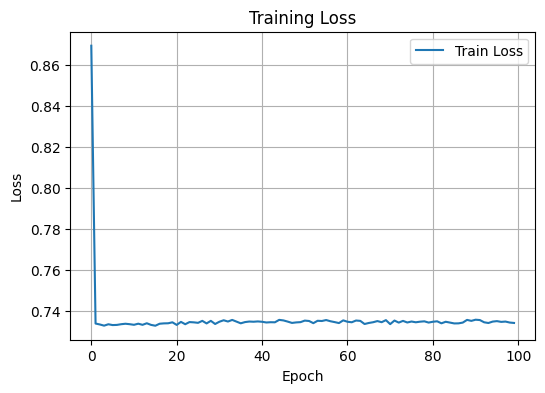

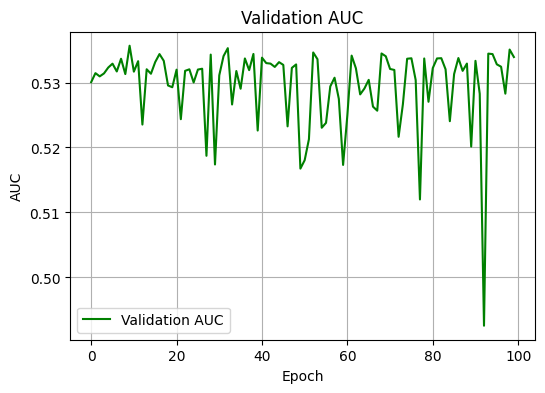

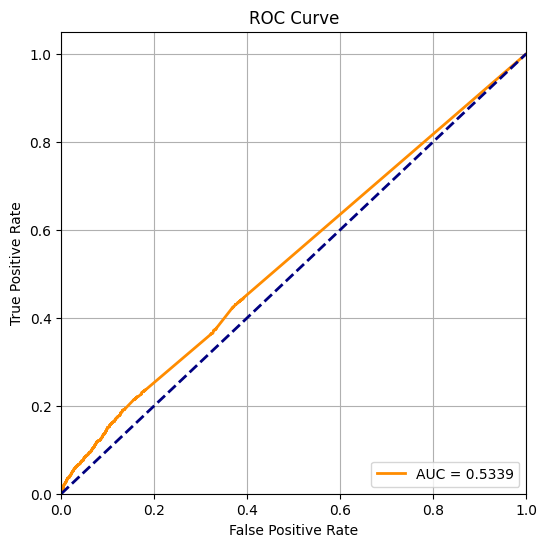

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# ===== 1. Vẽ biểu đồ Training Loss =====
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

# ===== 2. Vẽ biểu đồ Validation AUC =====
plt.figure(figsize=(6, 4))
plt.plot(val_aucs, label='Validation AUC', color='green')
plt.title('Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid(True)
plt.legend()
plt.show()

# ===== 3. Vẽ biểu đồ ROC Curve =====
fpr, tpr, thresholds = roc_curve(val_labels, val_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


<Figure size 500x500 with 0 Axes>

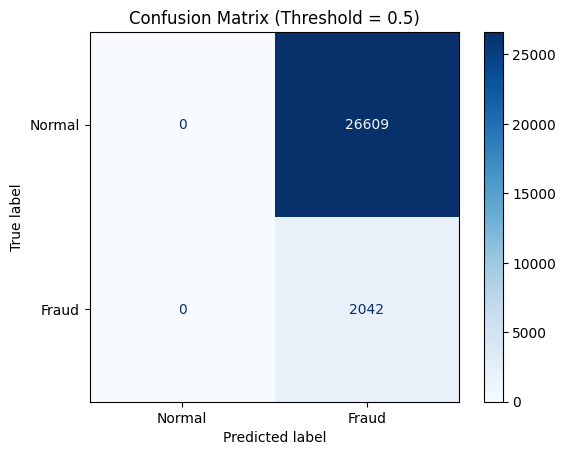

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Dự đoán nhị phân từ xác suất (probabilities)
threshold = 0.5
val_preds = (val_probs >= threshold).astype(int)

# 2. Tính confusion matrix
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fraud"])

# 3. Vẽ
plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.grid(False)
plt.show()
